In [1]:
%load_ext autoreload
%autoreload 2

Empezamos importando los librerias que vamos a utilizar:

In [28]:
# import ml_pro_packages
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Lectura del dataset y separación entre los datos independientes (predictores) y dependientes (target)

In [4]:
heart_df = pd.read_csv('../data/external/heart.csv')

heart_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


Guardamos nuestro dataset sin la columna de target

In [5]:
X = heart_df.drop(['target'], axis=1)
y = heart_df['target']

In [6]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2


In [7]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

Normalización de datos (paso indispensable para utilizar de forma correcta PCA) y creación de datos particiones de entrenamiento y testing.

In [8]:
# Normalizamos los datos
X = StandardScaler().fit_transform(X)

In [29]:
# Partir el conjunto de entrenamiento.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
print("X_train_Shape: ", X_train.shape)
print("y_train_Shape: ", y_train.shape)

X_train_Shape:  (717, 13)
y_train_Shape:  (717,)


Nota sobre el funcionamiento de StandardScaler de Sklearn
La estandarizacion que hace sklearn con StandardScaler es: 
- z = (x - u) / s
- x = valor
- u = media
- s = desviacion estandar

Implementación del Algoritmo PCA e IPCA

Empecemos por instanziar un modelo de clasificación que nos sirva para comparar el rendimiento de nuestros nuevos features utilizando PCA

In [16]:
# Configuracion de la regresion logistica

logistic = LogisticRegression(solver='lbfgs', max_iter=10_000)

Ahora entrenemos a nuestro algoritmo PCA con nuestros datos de entrada, algo importante a mencionar es que por defecto el número de componentes que utiliza PCA es el mínimo entre la cantidad de muestras y la cantidad de features, pero en general nosotros buscamos tener un valor más pequeño que el número de features de tener el mismo entonces no tendría mucho sentido usar PCA.

In [17]:
# PCA

# Llamamos y configuramos nuestro algoritmo PCA
# El numero de componentes es opcional
# Si no le pasamos el número de componentes lo asignará de esta forma:
# a: n_components = min(n_muestras, n_features)
pca = PCA(n_components=3)
# Entreando el agoritmo de PCA
pca.fit(X_train)

PCA(n_components=3)

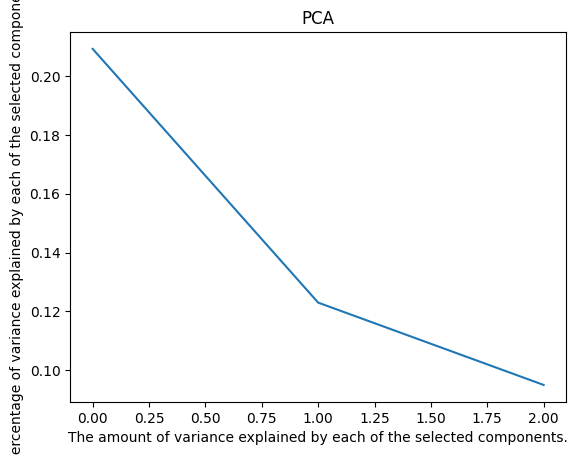

In [20]:
plt.plot(range(len(pca.explained_variance_)), pca.explained_variance_ratio_)
plt.title("PCA")
plt.xlabel("The amount of variance explained by each of the selected components.")
plt.ylabel("Percentage of variance explained by each of the selected components")
plt.show()

Ahora que nuestro algoritmo de PCA ha sido entrenado, debemos transformar nuestros datos de dependientes (X) de entrenamiento y validación utilizando PCA esto para que el modelo de regresión logística NO utilice las 13 features originales, sino en este caso solamente 3.

In [21]:
# Configramos los datos de entrenamiento con PCA
train_df = pca.transform(X_train)
test_df = pca.transform(X_test)

# Entrenamos la regresion logistica con datos del PCA
logistic.fit(train_df, y_train)

LogisticRegression(max_iter=10000)

Finalmente, podemos observar cuál es el Accuracy de nuestro modelo.

In [23]:
# Calculamos nuestra exactitud de nuestra prediccion
print("Score / Accuracy PCA: ", logistic.score(test_df, y_test) * 100)

Score / Accuracy PCA:  78.57142857142857


Ahora podemos repetir la metodología pero para IPCA y comparar los resultados:

In [24]:
# IPCA
# Haremos una comparacion con incremental PCA, haremos lo mismo para el IPCA.
# El parametro batch se usa para crear pequeños bloques,
# de esta forma podemos ir entrenandolos poco a poco y combinarlos en el resultado final

ipca = IncrementalPCA(n_components=3, batch_size=10)

# Entrenado el agoritmo
ipca.fit(X_train)

IncrementalPCA(batch_size=10, n_components=3)

In [25]:
#  Configuramos los datos de entrenamiento con IPCA
train_df = ipca.transform(X_train)
test_df = ipca.transform(X_test)

# Entrenamos la regresion logistica con datos del IPCA
logistic.fit(train_df, y_train)

LogisticRegression(max_iter=10000)

In [26]:
print("Score \ Accuracy IPCA: ", logistic.score(test_df, y_test) * 100)

Score \ Accuracy IPCA:  80.51948051948052


Bonus: Comparar el accuracy de PCA e IPCA utilizando diferentes valores en n_components

I'm running PCA
PCA with n_componentes = 1 give us 0.7694805194805194 Accuracy
PCA with n_componentes = 2 give us 0.7987012987012987 Accuracy
PCA with n_componentes = 3 give us 0.7857142857142857 Accuracy
PCA with n_componentes = 4 give us 0.8214285714285714 Accuracy
PCA with n_componentes = 5 give us 0.827922077922078 Accuracy
PCA with n_componentes = 6 give us 0.8181818181818182 Accuracy
PCA with n_componentes = 7 give us 0.8181818181818182 Accuracy
PCA with n_componentes = 8 give us 0.8181818181818182 Accuracy
PCA with n_componentes = 9 give us 0.8376623376623377 Accuracy
PCA with n_componentes = 10 give us 0.801948051948052 Accuracy
PCA with n_componentes = 11 give us 0.801948051948052 Accuracy
PCA with n_componentes = 12 give us 0.8051948051948052 Accuracy
PCA with n_componentes = 13 give us 0.8051948051948052 Accuracy
I'm running IPCA
IPCA with n_componentes = 1 give us 0.7694805194805194 Accuracy
IPCA with n_componentes = 2 give us 0.7922077922077922 Accuracy
IPCA with n_compone

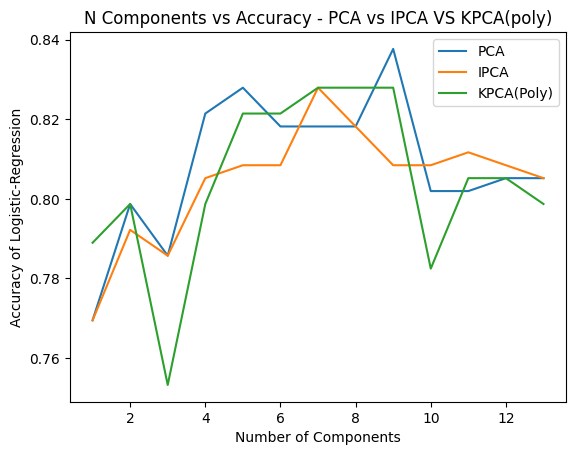

In [37]:
# Bonus
max_features = X_train.shape[1]  # El máximo número de features en este caso sería de 13
pca_data = {'accuracy': [],
            'n_components': []}
ipca_data = {'accuracy': [],
             'n_components': []}
kpca_data = {'accuracy': [],
             'n_components': []}
# PCA
print("I'm running PCA")
for n in range(1, max_features+1):
    pca = PCA(n_components=n)
    pca.fit(X_train)
    df_train = pca.transform(X_train)
    df_test = pca.transform(X_test)
    logistic.fit(df_train, y_train)
    acccuracy = logistic.score(df_test, y_test)
    print(f"PCA with n_componentes = {n} give us {acccuracy} Accuracy")
    pca_data['accuracy'].append(acccuracy)
    pca_data['n_components'].append(n)

# IPC
print("I'm running IPCA")
for n in range(1, max_features+1):
    ipca = IncrementalPCA(n_components=n, batch_size=max_features+1)
    ipca.fit(X_train)
    df_train = ipca.transform(X_train)
    df_test = ipca.transform(X_test)
    logistic.fit(df_train, y_train)
    acccuracy = logistic.score(df_test, y_test)
    print(f"IPCA with n_componentes = {n} give us {acccuracy} Accuracy")
    ipca_data['accuracy'].append(acccuracy)
    ipca_data['n_components'].append(n)
    
print("I'm running KPCA POLY")
for n in range(1, max_features+1):
    kpca = KernelPCA(n_components=n, kernel='poly')
    kpca.fit(X_train)
    df_train = kpca.transform(X_train)
    df_test = kpca.transform(X_test)
    logistic.fit(df_train, y_train)
    acccuracy = logistic.score(df_test, y_test)
    print(f"KPCA (POLY) with n_componentes = {n} give us {acccuracy} Accuracy")
    kpca_data['accuracy'].append(acccuracy)
    kpca_data['n_components'].append(n)

plt.plot(pca_data['n_components'], pca_data['accuracy'], label='PCA')
plt.plot(ipca_data['n_components'], ipca_data['accuracy'], label='IPCA')
plt.plot(kpca_data['n_components'], kpca_data['accuracy'], label='KPCA(Poly)')
plt.title('N Components vs Accuracy - PCA vs IPCA VS KPCA(poly)')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy of Logistic-Regression')
plt.legend()
plt.show()

Y aquí viene la única y principal diferencia respecto al código anterior, la instancia a PCA aplicado con Kernel.

In [31]:
# KPCA
# Alternativas a kernal, "linear, poly, rbf"
kpca = KernelPCA(n_components=4, kernel='poly')
kpca.fit(X_train)

KernelPCA(kernel='poly', n_components=4)

Recordemos que PCA NO es un clasificador, únicamente es una forma de reducir la dimensionalidad de nuestros datasets, sin embargo pese a no clasificar los datos, es necesario entrenarlo sobre nuestro conjunto de datos de entrenamiento. Una vez el modelo haya sido entrenado entonces puede ser utilizado para transformar a los datos de entrada de entrenamiento y validación y estos modelos ya transformados son los que usaremos en nuestro clasificador de cabecera.

In [32]:
# Configuramos los datos de entrenamiento con PCA
train_df = kpca.transform(X_train)
test_df = kpca.transform(X_test)

Ya con los datos transformados por KPCA entonces podemos proceder a entrenar y evaluar a nuestro modelo:

In [33]:
# Entrenando algoritmos de KPCA
# Entrenamiento la regresion logistica con datos del PCA
logistic.fit(train_df, y_train)

LogisticRegression(max_iter=10000)

In [35]:
# Calculamos nuestra exactitud de nuestra prediccion
print("Score / Accuracy KPCA: ", logistic.score(test_df, y_test) * 100)

Score / Accuracy KPCA:  79.87012987012987
